In [ ]:
!pip install tensorflow
!pip install panda
!pip install -U scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=678819aaafd54fc209cfaac531b929bb1be6c7be379dad2fc4e94dec99b871ed
  Stored in directory: /root/.cache/pip/wheels/0e/8b/c3/ff9cbde1fffd8071cff8367a86f0350a1ce30a8d31b6a432e9
Successfully built panda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve


# image processing

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from keras import layers
from keras.models import Sequential, Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

from tensorflow import keras

In [ ]:
!unzip /content/dataset.zip -d dataset
#!rm -r dataset.zip

Archive:  /content/dataset.zip
 extracting: dataset/README.dataset.txt  
 extracting: dataset/README.roboflow.txt  
   creating: dataset/test/
   creating: dataset/test/fashion/
 extracting: dataset/test/fashion/phoi-do-nam-2_jpg.rf.f9f9bf4c8c09ed85f0508ea747a03c26.jpg  
 extracting: dataset/test/fashion/thoi-trang-nam-he-2022-2_webp.rf.521e7571c610e2df759c713965f5b98d.jpg  
   creating: dataset/test/shoes_sandal/
 extracting: dataset/test/shoes_sandal/4550344414637_1260_jpg.rf.e179f27a8887b1d074c93f03f1dd4eb1.jpg  
 extracting: dataset/test/shoes_sandal/upload_30875dc639374d8ea5a1ce2911ef49e3_master_webp.rf.bfe20aa9b5cc4f4bee56740e44a5e4ea.jpg  
   creating: dataset/train/
   creating: dataset/train/fashion/
 extracting: dataset/train/fashion/ao-polo-at38_jpg.rf.45940ae757d277d9ae339d611c3451ee.jpg  
 extracting: dataset/train/fashion/ao-polo-at38_jpg.rf.513bcc0d177b2dc8d2ffc43ef77a99d0.jpg  
 extracting: dataset/train/fashion/ao-polo-at38_jpg.rf.b9cebfeff7f59867184906f5b1b4df6e.jpg  

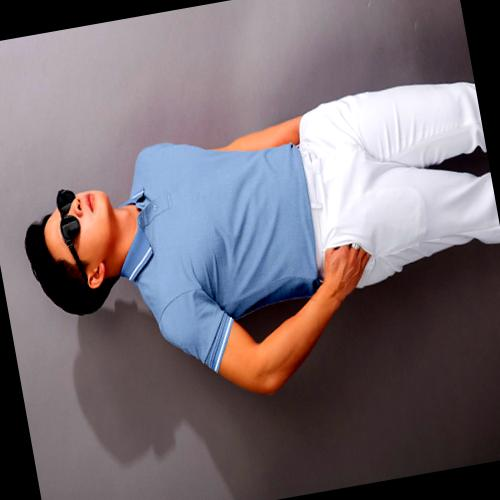

In [ ]:
# fashion
img_fashion = image.load_img("/content/dataset/train/fashion/ao-polo-at38_jpg.rf.513bcc0d177b2dc8d2ffc43ef77a99d0.jpg")
img_fashion

In [ ]:
class_names = ['fashion','shoes_sandal','mobile_phone']
datagen = ImageDataGenerator()

In [ ]:
# training data
train_generator = datagen.flow_from_directory(
    directory="/content/dataset/train/",
    classes = class_names,
    target_size=(500, 500),
    batch_size=32,
    class_mode="binary",
)

Found 72 images belonging to 3 classes.


In [ ]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory="/content/dataset/valid/",
    classes = class_names,
    target_size=(500, 500),
    batch_size=32,
    class_mode="binary",
)

Found 12 images belonging to 3 classes.


In [ ]:
# test data
test_generator = datagen.flow_from_directory(
    directory="/content/dataset/test/",
    classes = class_names,
    target_size=(500, 500),
    batch_size=32,
    class_mode="binary",
)

Found 4 images belonging to 3 classes.


In [ ]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(500,500,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 506, 506, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 250, 250, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 250, 250, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

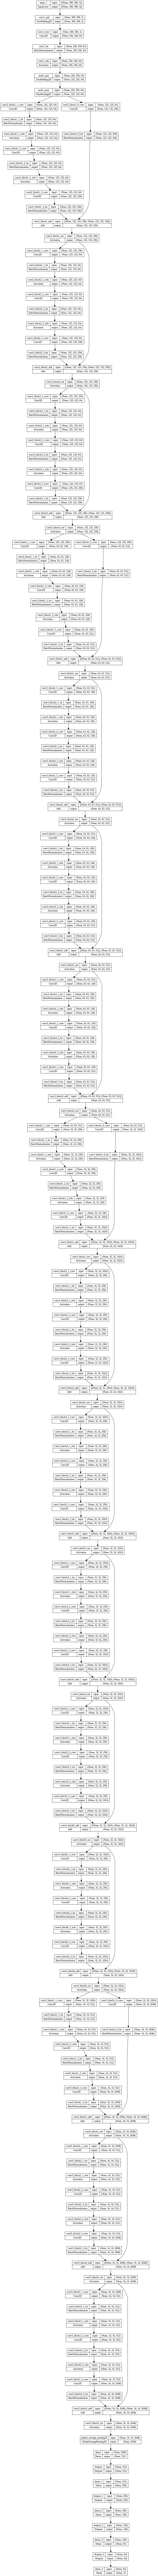

In [ ]:
# define training function
batch_size = 32
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
plot_model(model, to_file="rnet-50-tl.png", show_shapes=True)

In [ ]:
# launch the training
model_history = model.fit(train_generator, validation_data=valid_generator, epochs=32, batch_size=batch_size)

Epoch 1/32
3/3 [==============================] - 29s 5s/step - loss: 2.7390 - accuracy: 0.1806 - val_loss: 1.2986 - val_accuracy: 0.6667
Epoch 2/32
3/3 [==============================] - 2s 452ms/step - loss: 1.9560 - accuracy: 0.3194 - val_loss: 1.1559 - val_accuracy: 0.5833
Epoch 3/32
3/3 [==============================] - 2s 454ms/step - loss: 2.1531 - accuracy: 0.2083 - val_loss: 1.1576 - val_accuracy: 0.2500
Epoch 4/32
3/3 [==============================] - 2s 687ms/step - loss: 1.9997 - accuracy: 0.3194 - val_loss: 1.1203 - val_accuracy: 0.2500
Epoch 5/32
3/3 [==============================] - 2s 691ms/step - loss: 1.9644 - accuracy: 0.3333 - val_loss: 1.0260 - val_accuracy: 0.5833
Epoch 6/32
3/3 [==============================] - 2s 453ms/step - loss: 1.8822 - accuracy: 0.3194 - val_loss: 1.0407 - val_accuracy: 0.2500
Epoch 7/32
3/3 [==============================] - 2s 462ms/step - loss: 1.7234 - accuracy: 0.3889 - val_loss: 1.0777 - val_accuracy: 0.2500
Epoch 8/32
3/3 [======

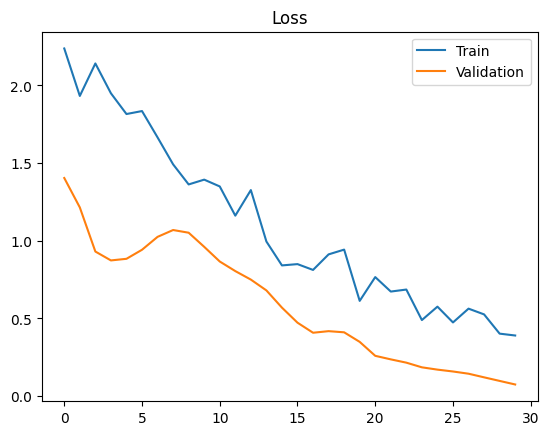

In [ ]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

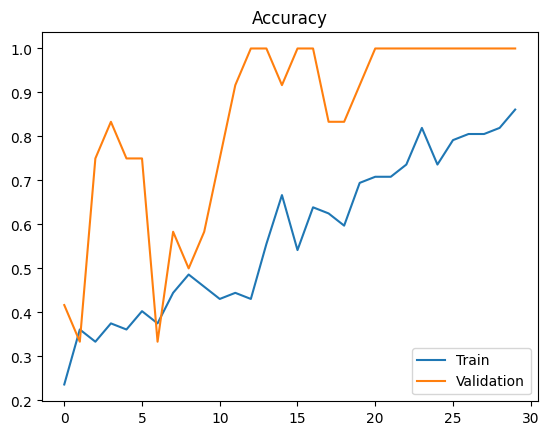

In [ ]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

1/1 [==============================] - 0s 152ms/step - loss: 0.0517 - accuracy: 1.0000
The test loss is:  0.051747120916843414
The best accuracy is:  100.0


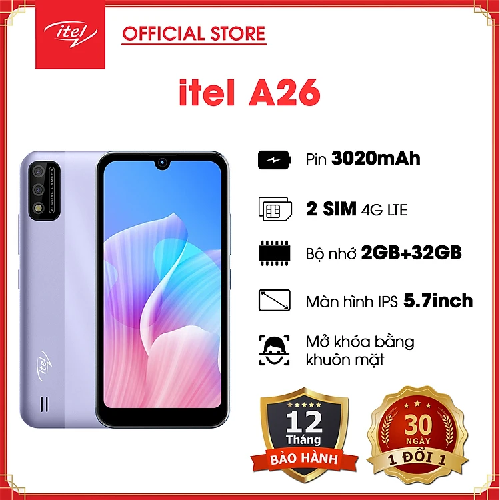

In [ ]:
img = keras.preprocessing.image.load_img('/content/a288f7276d63c8b23ecfc73c8375914b.jpg.webp',
                                            target_size=(500, 500))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
img

In [ ]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)


1/1 [==============================] - 1s 1s/step
[[0.05560258 0.03516398 0.88070595 0.01449944 0.01402816]]


In [ ]:
# transform classes number into classes name
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
class_names[class_id.item()]

'mobile_phone'

In [ ]:
model.save('tf_model_052024.h5',include_optimizer=False)

In [ ]:
# !rm -r /content/classify_product_model
!zip -r model.zip /content/classify_product_model

  adding: content/classify_product_model/ (stored 0%)
  adding: content/classify_product_model/variables/ (stored 0%)
  adding: content/classify_product_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/classify_product_model/variables/variables.index (deflated 80%)
  adding: content/classify_product_model/saved_model.pb (deflated 92%)
  adding: content/classify_product_model/fingerprint.pb (stored 0%)
  adding: content/classify_product_model/keras_metadata.pb (deflated 96%)
  adding: content/classify_product_model/assets/ (stored 0%)
